# Proyecto Machine Learning
## XGBOOST
### Dataset Cáncer de Mama

El objetivo de este proyecto es que a partir de datos clínicos **(1902 filas y 517 columnas)** en una RNA utilizando **XGBOOST** pronostique los fallecimientos por Cáncer de Mama y así podamos sacar las variables que nuestro algoritmo o modelo ha considerado importantes para pronosticar estos sucesos.
La finalidad es investigar estos parámetros/proteínas/receptores de modo que sean de utilidad para futuros pacientes o para pacientes precoces para actuar de una forma más rápida o investigar estos supuestos.

link data : https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric

### LIBRERIAS

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

### PATH Y VISUALIZACIÓN DE DATOS

In [2]:
# PATH
path = "C:/Users/USUARIO/Desktop/Jupyter/DATA/"
data = pd.read_csv(path + "METABRIC_RNA_Mutation.csv")

In [3]:
data.head(10)

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
5,10,78.77,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,0,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
6,14,56.45,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
7,22,89.08,BREAST CONSERVING,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
8,28,86.41,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,0,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
9,35,84.22,MASTECTOMY,Breast Cancer,Breast Invasive Lobular Carcinoma,High,0,Her2,1.0,Negative,...,0,0,0,0,0,0,0,0,0,0


### Preprocesado
Limpieza de datos nulos y columnas no dependientes del modelo

In [4]:
print(data.isnull().sum())

patient_id                 0
age_at_diagnosis           0
type_of_breast_surgery    22
cancer_type                0
cancer_type_detailed      15
                          ..
hras_mut                   0
prps2_mut                  0
smarcb1_mut                0
stmn2_mut                  0
siah1_mut                  0
Length: 693, dtype: int64


In [5]:
data = data.iloc[:,1:-1] # Quitamos las id
data = data.dropna() # Quitamos valores con null , filas totales 1092

### Selección de datos
Separamos nuestros datos del dataframe en variables dependientes o independientes.
Almacenamos solamente las columnas que realmente tienen valores relevantes para nuestro algoritmo ya que por ejemplo las columnas hacía la derecha de **ugt2b7** toman valores nulos y en 0. Entonces no van a tener un peso estadístico en el problema y son irrelevantes. Entonces tomamos los siguientes datos:

- La X, todas las columnas menos **'overall_survival', 'death_from_cancer' y las demás columnas hacia la derecha de ugt2b7** . Siendo estos los valores independientes.
- La Y, con la columna de valores booleanos de **'overall_survival'**. Siendo este el valor dependiente.


**Retroalimentación:**

En la 1º propuesta de estudio el algoritmo reconoció la columna **death_from_cancer'** era totalmente dependiente de **overrall_survival** y daba un **100% de precision** de modo que la elimino para que empiece a dar peso a otras columnas y asi averiguar que columnas son determinantes para nuestro modelo.

In [6]:
X = data.drop(['overall_survival', 'death_from_cancer'],axis=1)
X = X.loc[:, :'ugt2b7'] # Despreciamos alrededor de 100 columnas con valores nulos 
Y = data.loc[: , ['overall_survival']]   # Personas que han sobrevivido o no

### Transformación de datos

En el dataframe existen variables tipo object de modo que las transformo con el metodo LabelEnconder(). Previamente recojo por la condiccion if el tipo object para que solo me seleccione las columnas que son tipo object.

In [7]:
# Tipo de dato objeto para convertir el labelenconder de objeto a variable categorica
tpro2 = X.iloc[:, 1].dtypes # object
max = len(X.columns)
le = LabelEncoder()

In [8]:
# Codificamos los objetos para cada columna
for i in range(max):
    if ( X.iloc[:,i].dtypes == tpro2):
        X.iloc[:, i] = le.fit_transform(X.iloc[:, i])

### TRAIN Y TEST
Después de limpiar, preprocesar los datos, considerar que columnas son irrelavantes para nuestro modelo y transformar nuestros dato tipo texto a numérico ahora ya se pasaría a la fase de división de datos, es decir, considerar cuanto porcentaje de datos del dataset sería para entrenar nuestro modelo y el otro para testearlo y verificar su precisión. Normalmente:

- TRAIN, tiene el 80% de datos del dataset original ya que cuanto más datos más comprobaciones realizará y más fiable será.
- TEST, tiene el 20% de datos del dataset original y con él se mide la precisión.

Como sería un proceso muy laborioso hacerlo manualmente con está gran cantidad de datos hay una función en Python del modulo sklearn llamada train_test_split que nos facilita esta división de datos.

In [9]:
# Dividimos los datos usando la funcion train_test_split para Train Y test del modelo
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

### XGBOOST
XGBoost es una biblioteca de aumento de gradiente distribuida optimizada diseñada para ser altamente eficiente , flexible y portátil . Implementa algoritmos de aprendizaje automático bajo el marco Gradient Boosting . XGBoost proporciona un impulso de árbol paralelo (también conocido como GBDT, GBM) que resuelve muchos problemas de ciencia de datos de una manera rápida y precisa

In [10]:
# Llamamos a la funcion XGBOOST y creamos un objeto. Ajustamos el modelo y lo entrenamos
XGBOOST = XGBClassifier()
XGBOOST.fit(X_train, y_train)

# Con el modelo entrenado, hacemos una prediccion de los datos del testing
y_pred = XGBOOST.predict(X_test)

### TESTING DEL MODELO ENTRENADO
Hacemos la matriz de confusión para evaluar los datos, se observa en ella que tenemos **169 personas acertadas**  con nuestro pronóstico  y **50 falsos positivos-negativos** del test de datos de **219 personas**. **Precisión 77'16%**

In [12]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[101  21]
 [ 29  68]]


In [16]:
print( "PRECISION :" + str(((101+68)/219) * 100) )

PRECISION :77.1689497716895


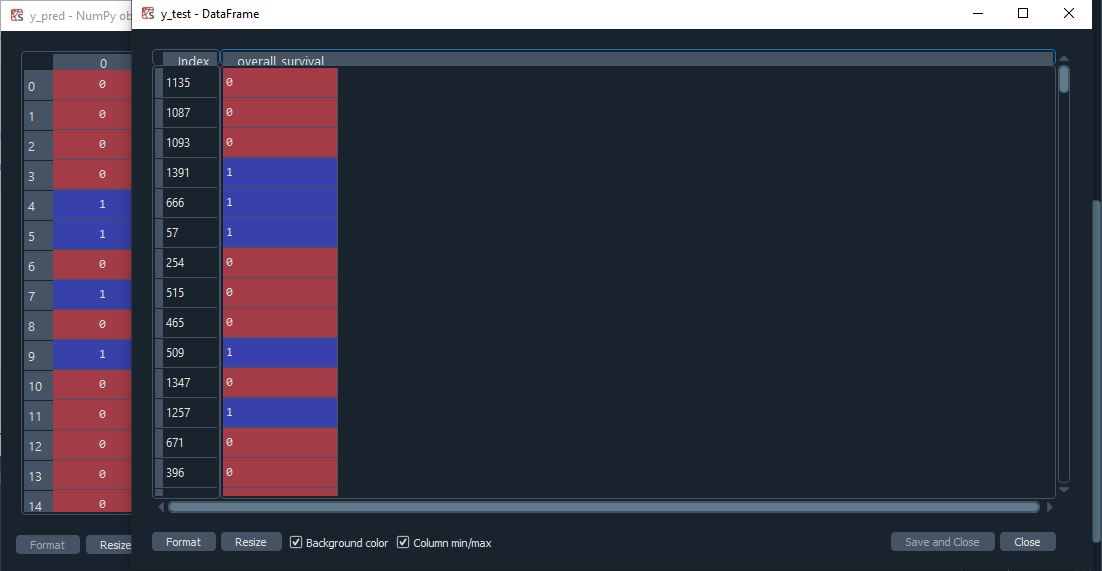

In [17]:
from IPython.display import Image
Image("C:/Users/USUARIO/Desktop/Jupyter/DATA/PrediccionCM.jpg")

### K-FOLD VALIDATION
Aplicamos el algoritmo de K-fold cross de validacion para medir la precisión de nuestro algoritmo
teniendo asi una mejor medida (validacion cruzada).
Como resultado obtengo una precisión óptima del modelo.

In [19]:
accuracies = cross_val_score(estimator = XGBOOST, X = X_train, y = y_train, cv = 10)
print("Precision: {:.2f} %".format(accuracies.mean()*100))
print("Desviacion estandar: {:.2f} %".format(accuracies.std()*100))

Precision: 76.29 %
Desviacion estandar: 2.51 %


### MODELO ENTRENADO
Como ya está el modelo entrenado y tengo una precisión óptima del **76%** ahora voy a sacar las columnas que el modelo de XGBOOST ha considerado importantes para pronosticar los casos clínicos del estudio de cáncer de mama.

In [20]:
# Vamos a ver que columnas le ha dado mas importancia para nuestro modelo
colummnas_importancia = XGBOOST.feature_importances_
columnasnombres = XGBOOST.feature_names_in_
dataXgboost = pd.DataFrame(colummnas_importancia, columnasnombres)
dataXgboost = dataXgboost.rename(columns={0:'Importancia %'})
orden_desce = dataXgboost.sort_values('Importancia %',ascending=False)

In [22]:
print(orden_desce.head(20))

                         Importancia %
erbb2                         0.018316
folr2                         0.018266
psen1                         0.016744
cohort                        0.016728
rps6                          0.015055
stmn2                         0.014747
or6a2                         0.014075
csf1r                         0.013306
folr1                         0.013133
overall_survival_months       0.012892
foxo3                         0.012499
cyp17a1                       0.012377
rad51c                        0.011998
gdf2                          0.011766
aurka                         0.010807
bmp6                          0.010365
dph1                          0.009674
e2f1                          0.009483
cdkn2c                        0.009194
casp3                         0.009009


## Conclusión
Podemos observar que estas columnas/características son significativas para nuestro algoritmo en menos de un 2%. Ahora conociendo estos datos podríamos hacer nuestro caso de estudio con los pacientes que presentaran estas características/proteinas/receptores en los informes. Por ejemplo:
- **erbb2**, es un receptor que muta en algunos cánceres de mama.
- **folr2**, Proteina FOLR2 folate receptor beta [(human)]
- **cohort**, es un grupo de sujetos que comparten una característica definitoria (Toma un valor de 1 a 5)
- ...

**Autor: Carlos Mir Martínez**

**Fecha:21/05/2022**